In [3]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
import os
import zipfile

In [4]:
path = "C:\\Users\\user\\Desktop\\Python2\\Lab2\\set\\dataset.csv"
dframe = pd.read_csv(
    path, delimiter=",", names=["Absolute path", "Relative path", "Class"]
)
img_list = dframe["Absolute path"].tolist()
random.shuffle(img_list)
print(img_list[:5]) 

['C:\\Users\\user\\Desktop\\Python2\\dataset\\dog\\0540.jpg', 'C:\\Users\\user\\Desktop\\Python2\\dataset\\cat\\0286.jpg', 'C:\\Users\\user\\Desktop\\Python2\\dataset\\cat\\0830.jpg', 'C:\\Users\\user\\Desktop\\Python2\\dataset\\dog\\0252.jpg', 'C:\\Users\\user\\Desktop\\Python2\\dataset\\cat\\0673.jpg']


In [5]:
img_label=[]
for i in range(len(img_list)):
    img_label.append(os.path.basename(os.path.dirname(img_list[i])))
print(img_label[:5])

['dog', 'cat', 'cat', 'dog', 'cat']


In [6]:
training_list = img_list[0 : int(len(img_list) * 0.8)]
testing_list = img_list[int(len(img_list) * 0.8) : int(len(img_list) * 0.9)]
validation_list = img_list[int(len(img_list) * 0.9) : int(len(img_list))] 
print(len(training_list ), len(testing_list), len(validation_list))

1612 202 202


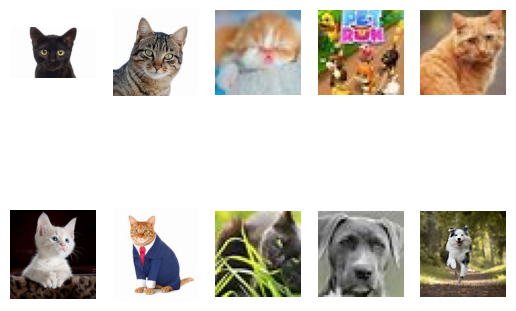

In [16]:
random_idx = np.random.randint(1,len(img_list),size=10)
fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i) 
    img = Image.open(img_list[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off') 
plt.show()

In [17]:
class dataset(torch.utils.data.Dataset):  
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    # dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    # load an one of images
    def __getitem__(self, idx):
        img_label = []
        for i in range(len(self.file_list)):
            img_label.append(os.path.basename(
                os.path.dirname(self.file_list[i])))
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_label[idx]
        if label == "cat":
            label = 0
        elif label == "dog":
            label = 1
        return img_transformed, label

In [18]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
train_data = dataset(training_list, transform=transform)
test_data = dataset(testing_list, transform=transform)
val_data = dataset(validation_list, transform=transform)
print(len(train_data), len(test_data), len(val_data))
train_data[0][0].shape

1612 202 202


torch.Size([3, 224, 224])

In [19]:
class Cnn(nn.Module):
    '''класс построения сверточной модели'''

    def __init__(self):
        super(Cnn, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc1 = nn.Linear(3 * 3 * 64, 10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
model = Cnn()
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [21]:
def show_results(epochs, acc, loss, val_acc, val_loss) -> None: 
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(range(epochs), acc, color="green", label="Train")
    ax[1].plot(range(epochs), loss, color="green", label="Train")
    ax[0].plot(range(epochs), val_acc, color="crimson", label="Validation")
    ax[1].plot(range(epochs), val_loss, color="crimson", label="Validation")
    ax[0].set_title('Accuracy')
    ax[1].set_title('Loss')
    ax[0].legend()
    ax[1].legend()
    fig.suptitle('The result of the training')
    plt.show()

In [22]:
def train_loop(epochs, batch_size, lear) -> None:
    optimizer = optim.Adam(params = model.parameters(),lr=lear)
    criterion = nn.CrossEntropyLoss() 
    accuracy_values = []
    loss_values = []
    val_accuracy_values=[]
    val_loss_values=[]
    val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)
    train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True ) 
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)
            
        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())
        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device) 
                
                val_output = model(data)
                val_loss = criterion(val_output,label) 
                
                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)
                
            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
            val_accuracy_values.append(epoch_val_accuracy.item())
            val_loss_values.append(epoch_val_loss.item()) 
    show_results(epochs,accuracy_values, loss_values, val_accuracy_values, val_loss_values)

In [24]:
cat_probs = []
model.eval()
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=100, shuffle=False)
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        cat_probs += list(zip(list(fileid), preds_list))
cat_probs.sort(key = lambda x : int(x[0]))
cat_probs[:10]

[(tensor(0), 0.457681804895401),
 (tensor(0), 0.4553642272949219),
 (tensor(0), 0.4545372724533081),
 (tensor(0), 0.4589231312274933),
 (tensor(0), 0.4564065933227539),
 (tensor(0), 0.4562707245349884),
 (tensor(0), 0.45907890796661377),
 (tensor(0), 0.4586814343929291),
 (tensor(0), 0.458159476518631),
 (tensor(0), 0.4579206109046936)]

In [25]:
id = list(range(len(cat_probs)))
label = list(map(lambda x: x[1], cat_probs))
submission = pd.DataFrame({'id':id, 'label':label})
# submission.to_csv('final.csv', index=False)
submission

,id,label
0,0,0.457682
1,1,0.455364
2,2,0.454537
3,3,0.458923
4,4,0.456407
...,...,...
197,197,0.458903
198,198,0.457622
199,199,0.457842
200,200,0.457889


In [56]:
torch.save(model.state_dict(), os.path.join("C:\\Users\\user\\Desktop\\Python2\\Lab5", "lab5_final.pt")) 
mymodel = Cnn()
mymodel.load_state_dict(torch.load(os.path.join("C:\\Users\\user\\Desktop\\Python2\\Lab5", "lab5_final.pt")))

<All keys matched successfully>